# Emergence of Low-level Mathematical Operations in MLPs

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import random

## Global utilities

### Misc

In [35]:
def generate_seed():
    return np.random.randint(1, 2**32 - 1)


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Network

In [43]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(name, "\n", param.data, "\n")

### Data

In [40]:
def generate_data():
    eps = 0.5

    Y = torch.rand(10000)
    X = torch.empty(10000, 2)
    X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
    mask = torch.rand(10000) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    assert torch.allclose(X[:, 0] * X[:, 1], Y)

    Y = Y[:, None]

    # Train/valid split

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
    ax.legend()

### Training/evaluation

In [33]:
def train(model, data, lr=1e-2):
    N = 4000  # number of epochs

    X_train, Y_train, X_valid, Y_valid = data

    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=lr)
    log = []

    for i in tqdm(range(N)):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(X_train)
        loss = loss_func(Y_hat, Y_train)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(X_valid)
        loss = loss_func(Y_hat, Y_valid)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    df = pd.DataFrame(log)

    return model, df


def plot_loss(train_loss, valid_loss, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()
    ax.set_aspect("equal")


def plot_model_performance_summary(model, df, X_valid, Y_valid):
    _, axes = plt.subplots(2, 1, figsize=(6, 12))

    axes[0] = plot_loss(df["train_loss"], df["valid_loss"], ax=axes[0])

    y_preds, y_targs = get_preds(model, X_valid, Y_valid)
    plot_results(y_preds, y_targs, ax=axes[1])
    axes[1].set_title(f"Validation loss: {get_valid_loss(model, nn.MSELoss(), X_valid, Y_valid):.5f}")

### Analysis plots

## Toy Data

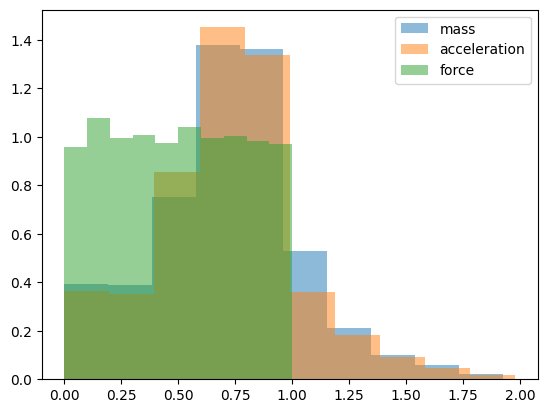

In [ ]:
plot_data_distribution(*generate_data()[:2])

## Experiments

### Single linear projection

  0%|          | 0/4000 [00:00<?, ?it/s]

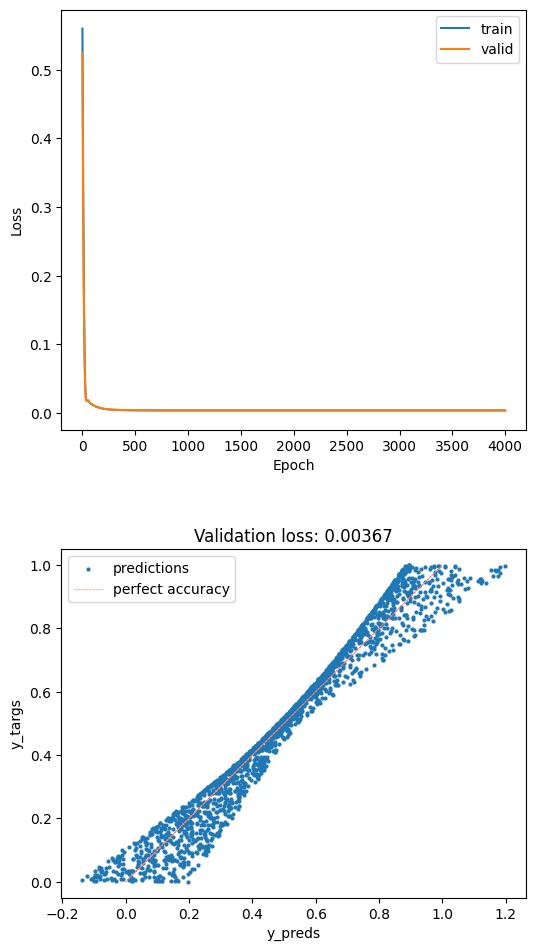

In [50]:
set_all_seeds(3768514969)
data = generate_data()
model = nn.Linear(2, 1)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])

In [44]:
print_model_parameters(model)

weight 
 tensor([[0.6979, 0.6907]]) 

bias 
 tensor([-0.5021]) 



### 2D hidden layer

  0%|          | 0/4000 [00:00<?, ?it/s]

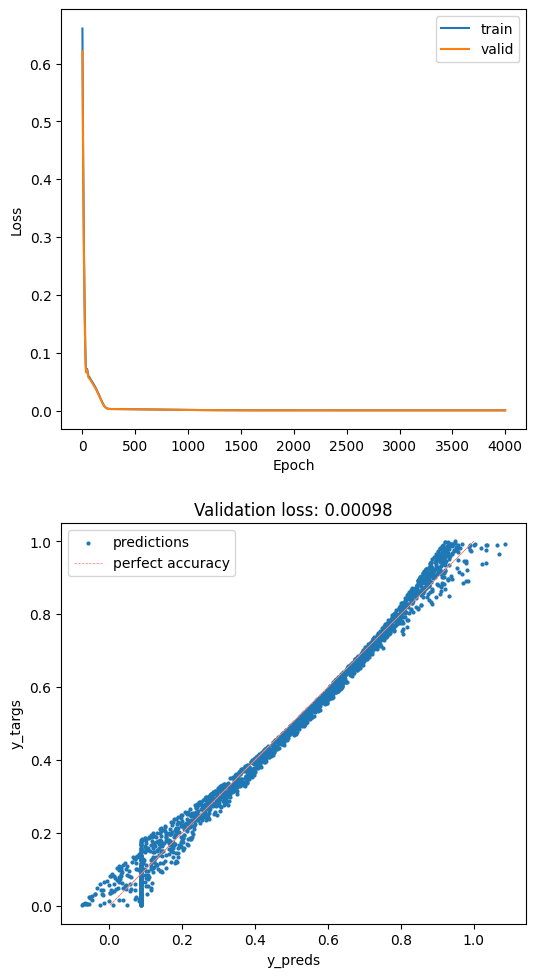

In [49]:
set_all_seeds(2432571267)
data = generate_data()
model = Net(use_act=True, dim=2)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])